<a href="https://colab.research.google.com/github/shubhjadhav/image-caption-generator/blob/main/Code/VGG_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install black[jupyter]
# !pip install --upgrade autopep8
# !black /content/drive/MyDrive/inception_lstm_gru/iInception_lstm_gru

# Mount Drive

In [1]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


# Import Libraries

In [27]:
import os
import string
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import keras
from keras.layers import Input, Dropout, Dense, LSTM, Embedding, Add, GRU, SimpleRNN
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence as kps
from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications import vgg16, VGG16
from keras.utils.vis_utils import model_to_dot

from IPython.display import SVG

%matplotlib inline


# Download Dataset

In [3]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

# Define Constants

In [4]:
text_folder = "/content/"
img_folder = "Flicker8k_Dataset"
pretrained_input_size = 224
key = "vgg_lstm_gru"
drive_path = f"drive/MyDrive/{key}"

glove_embed_path = os.path.join(drive_path, "glove.6B.50d.txt")
captions_path = os.path.join(text_folder, "Flickr8k.token.txt")
encodings_train_file_path = os.path.join(drive_path, "encoded_train_images.pkl")
encodings_test_file_path = os.path.join(drive_path, "encoded_test_images.pkl")
final_model_path = os.path.join(drive_path, "weights")

# Text Modules

In [5]:
def load_text(filename):
    """
    Load text from a file and return it as a list of strings.

    Inputs:
    - filename: The name of the file to load.

    Returns:
    - text: A list of strings representing the lines in the file.
    """
    # open the file as read only
    file = open(filename, "r")
    # read all text
    text = file.read()
    text = text.split("\n")
    # close the file
    file.close()
    return text

In [6]:
def caption_generator(photo, model, max_length, wordtoix, ixtoword):
    """
    Generate a caption for a given image using the specified model and vocabulary.

    Inputs:
    - photo: A numpy array representing the image.
    - model: A trained Keras model for generating captions.
    - max_length: The maximum length of the generated caption.
    - wordtoix: A dictionary mapping words to integer indices.
    - ixtoword: A dictionary mapping integer indices to words

    Returns:  A list of strings representing the generated caption, including the "startseq" and "endseq" tokens.

    """
    # start with 'startseq'
    in_text = ["startseq"]
    # iterate over the maximal length of description
    for s in range(max_length):
        seq = [wordtoix[i] for i in in_text]
        seq = tf.pad(
            seq,
            paddings=[[max_length - len(seq), 0]],
            mode="CONSTANT",
            constant_values=0,
        )
        in_put = [np.array([photo]), np.array([seq])]
        out_word = model.predict(in_put, verbose=0)
        # convert probability to integer
        out_word = np.argmax(out_word)
        # map ix to word
        out_word = ixtoword[out_word]
        # stop if we cannot map the word
        if out_word is None:
            break
        # append as input for generating the next word
        in_text.append(out_word)
        # stop if we predict the end of the sequence
        if out_word == "endseq":
            break
    return in_text

In [7]:
def load_descriptions(doc):
    """
    Load image descriptions from a text file and return them as a dictionary.

    Inputs:
    - doc: A list of strings representing the lines in the file.

    Returns:
    - mapping: A dictionary mapping image ids to their corresponding descriptions.
    """

    mapping = dict()
    # process lines
    for line in doc:
        # split line by white space
        tokens = line.split()
        if len(tokens) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # remove filename from image id
        image_id = image_id.split(".")[0]
        # convert description tokens back to string
        # add 'startseq' and 'endseq' to each description
        image_desc = "startseq " + " ".join(image_desc) + " endseq"
        # store the first description for each image
        if image_id not in mapping.keys():
            mapping[image_id] = []
        mapping[image_id].append(image_desc)
    return mapping

In [8]:
def clean_description(desc_dict):
    """
    Function:
      Takes a dictionary of image descriptions as input,
      Preprocesses the text by removing punctuation,
      Converts all words to lowercase,
      Removes words with length less than or equal to one,
      and joins the words back into a string.
    The function modifies the input dictionary in place.

    Inputs:
    - desc_dict: a dictionary of image descriptions, where the keys are image IDs and the values are lists
      of descriptions for each image.

    Returns: None
    """
    # prepare translation table for removing punctuation
    table = str.maketrans("", "", string.punctuation)
    for key, desc_list in desc_dict.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word) > 1]
            # store as string
            desc_list[i] = " ".join(desc)

In [9]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions, keys):
    """
    Given a dictionary of image descriptions and a list of image keys, returns a list of all the descriptions
    corresponding to the provided keys.

    Input:
    - descriptions: A dictionary where keys are image IDs and values are lists of preprocessed descriptions
      for each image.
    - keys: A list of image IDs for which descriptions are to be extracted.

    Returns:
    - all_desc: A list of all the preprocessed descriptions corresponding to the provided keys.
    """
    all_desc = list()
    for key in keys:
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

In [10]:
# calculate the length of the description with the most words
def max_length(descriptions, keys):
    """
    Finds Max Length

    Input:
    - descriptions: A dictionary where keys are image IDs and values are lists of preprocessed descriptions
      for each image.
    - keys: A list of image IDs for which descriptions are to be extracted.

    Returns: Find maximum length of description formt he input descriptions
    """
    lines = to_lines(descriptions, keys)
    return max(len(d.split()) for d in lines)

In [11]:
descriptions = load_text(captions_path)
desc_dict = load_descriptions(descriptions)
clean_description(desc_dict)

In [12]:
print(desc_dict["997722733_0cb5439472"])

['startseq man in pink shirt climbs rock face endseq', 'startseq man is rock climbing high in the air endseq', 'startseq person in red shirt climbing up rock face covered in assist handles endseq', 'startseq rock climber in red shirt endseq', 'startseq rock climber practices on rock climbing wall endseq']


# Image Modules

# Load Dataset

In [13]:
train_imgs = load_text(os.path.join(text_folder, "Flickr_8k.trainImages.txt"))
test_imgs = load_text(os.path.join(text_folder, "Flickr_8k.testImages.txt"))
dev_imgs = load_text(os.path.join(text_folder, "Flickr_8k.devImages.txt"))
train_imgs = [x for x in train_imgs if x != ""]
test_imgs = [x for x in test_imgs if x != ""]
dev_imgs = [x for x in dev_imgs if x != ""]

In [14]:
train_set_length = len(train_imgs)
test_set_length = len(test_imgs)
dev_set_length = len(dev_imgs)

In [15]:
print(train_set_length)
print(test_set_length)
print(dev_set_length)

6000
1000
1000


## Data Visualization

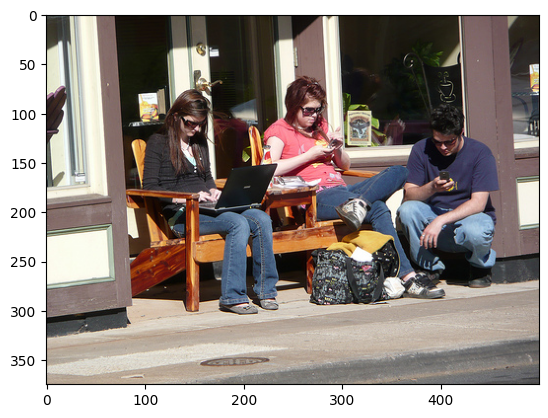

In [16]:
image1 = train_imgs[32]
imagepath = os.path.join(text_folder, img_folder, image1)
image_1 = Image.open(imagepath)
plt.imshow(image_1)

# Image Pretrained Model

In [17]:
def get_features(img_folder, img_name, model, in_size):
    """
    Takes an image file name,
    loads the image, resizes it to a specified input size,
    pre-processes it using a pre-trained model, and returns a feature vector of the image.

    Inputs:
        img_folder (str): The folder where the image is stored.
        img_name (str): The name of the image file.
        model (keras.Model): The pre-trained model to use for feature extraction.
        in_size (int): The size to which the image is resized.

    Returns:
        numpy.ndarray: A feature vector of the image.
    """

    # Convert all the images to size 299x299 as expected
    img = Image.open(os.path.join(img_folder, img_name))
    size = (in_size, in_size)
    img = img.resize(size)
    # Convert PIL image to numpy array of 3-dimensions
    x = np.asarray(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess images using preprocess_input() from inception module
    x = preprocess_input(x)
    x = model.predict(x)
    # reshape from (1, 2048) to (2048, )
    x = np.reshape(x, x.shape[1])
    return x

In [20]:
# Get the InceptionV3 model trained on imagenet data
pretrained_model = VGG16(weights="imagenet")

# Remove the last layer (output softmax layer) from the inception v3
pretrained_model = Model(pretrained_model.input, pretrained_model.layers[-2].output)

553467096/553467096 [==============================] - 15s 0us/step


In [ ]:
if os.path.isfile(encodings_train_file_path):
    with open(encodings_train_file_path, "rb") as file:
        encoded_train_images = pickle.load(file)
    print("Loaded variable:", len(encoded_train_images))
else:
    encoded_train_images = {}
    for i in range(0, train_set_length):
        encoded_train_images[train_imgs[i].split(".")[0]] = get_features(
            os.path.join(text_folder, img_folder),
            train_imgs[i],
            pretrained_model,
            pretrained_input_size,
        )
    with open(encodings_train_file_path, "wb") as file:
        pickle.dump(encoded_train_images, file)
    print("Variable saved to:", encodings_train_file_path)

In [ ]:
if os.path.isfile(encodings_test_file_path):
    with open(encodings_test_file_path, "rb") as file:
        encoded_test_images = pickle.load(file)
    print("Loaded variable:", len(encoded_test_images))
else:
    encoded_test_images = {}
    for i in range(0, test_set_length):
        if i % 1000 == 0:
            print(i)
        encoded_test_images[test_imgs[i].split(".")[0]] = get_features(
            os.path.join(text_folder, img_folder),
            test_imgs[i],
            pretrained_model,
            pretrained_input_size,
        )
    with open(encodings_test_file_path, "wb") as file:
        pickle.dump(encoded_train_images, file)
    print("Variable saved to:", encodings_test_file_path)

In [23]:
train_keys = []
for i in range(0, train_set_length):
    train_keys.append(train_imgs[i].split(".")[0])
len(train_keys)

6000

In [24]:
test_keys = []
for i in range(0, test_set_length):
    test_keys.append(test_imgs[i].split(".")[0])
len(test_keys)

1000

In [26]:
# Create the vocabulary.
embedding_dim = 50

vocabulary = set()
for key in desc_dict.keys():
    [vocabulary.update(d.split()) for d in desc_dict[key]]
vocabulary = list(vocabulary)
print("Original Vocabulary Size: %d" % len(vocabulary))


# Create the word <--> index mappers.
# NOTE: index starts from 1, not 0.
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocabulary:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

# Load Glove vectors
embeddings_index = {}  # empty dictionary
f = open(glove_embed_path, encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
f.close()
print("Volcabulary size of GLOVE: {}".format(len(embeddings_index)))
# Get 200-dim dense vector for each of words in vocabulary

vocab_size = len(vocabulary) + 1  # added 1 for padding
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    # if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

print(
    "Shape of embedding weights for the current vocabulary {}".format(
        embedding_matrix.shape
    )
)

Original Vocabulary Size: 8810
Volcabulary size of GLOVE: 400000
Shape of embedding weights for the current vocabulary (8811, 50)


# Data Loader

In [28]:
# define the data generator function
def data_generator(
    descriptions, img_keys, photos, wordtoix, max_length, num_photos_per_batch
):
    """
    Generator function that yields batches of data for training a captioning model.

    Inputs:
    - descriptions: Dictionary containing image ids as keys and a list of their corresponding
                    clean descriptions as values.
    - img_keys: List of image ids to use for generating data.
    - photos: Dictionary containing precomputed feature vectors for each image.
    - wordtoix: Dictionary mapping words to their respective integer index.
    - max_length: Maximum length of a sequence.
    - num_photos_per_batch: Number of images to use per batch.

    Yields:
    - Tuple containing two lists (inputs) and an array (output), which are used to train the model.
      The first input list contains the precomputed feature vectors for the images in the batch.
      The second input list contains the padded sequences of word indices for the corresponding
      descriptions in the batch. The output array contains the one-hot encoded target word for each
      sequence step in the descriptions.
    """
    X1, X2, y = list(), list(), list()
    n = 0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            if key in img_keys:
                n += 1
                # retrieve the photo feature
                photo = photos[key]
                for desc in desc_list:
                    # encode the sequence
                    seq = [
                        wordtoix[word] for word in desc.split(" ") if word in wordtoix
                    ]
                    # split one sequence into multiple X, y pairs
                    for i in range(1, len(seq)):
                        # split into input and output pair
                        in_seq, out_seq = seq[:i], seq[i]
                        # pad input sequence
                        in_seq = tf.pad(
                            in_seq,
                            paddings=[[max_length - len(in_seq), 0]],
                            mode="CONSTANT",
                            constant_values=0,
                        )
                        # encode output sequence
                        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                        # store
                        X1.append(photo)
                        X2.append(in_seq)
                        y.append(out_seq)
                # yield the batch data
                if n == num_photos_per_batch:
                    yield [[np.array(X1), np.array(X2)], np.array(y)]
                    X1, X2, y = list(), list(), list()
                    n = 0

In [29]:
train_max_len = max_length(desc_dict, train_keys)
print("Max Description Length: %d" % train_max_len)


# Generate Training Input
train_generator = data_generator(
    descriptions=desc_dict,
    img_keys=train_keys,
    photos=encoded_train_images,
    wordtoix=wordtoix,
    max_length=train_max_len,
    num_photos_per_batch=32,
)

train_inputs, train_outputs = next(train_generator)
print(train_inputs[0].shape)
print(train_inputs[1].shape)
print(train_outputs.shape)

Max Description Length: 34
(1754, 4096)
(1754, 34)
(1754, 8811)


In [30]:
val_max_len = max_length(desc_dict, test_keys)
print("Max Description Length: %d" % val_max_len)

# Generate Validation Input
validation_generator = data_generator(
    descriptions=desc_dict,
    img_keys=test_keys,
    photos=encoded_test_images,
    wordtoix=wordtoix,
    max_length=val_max_len,
    num_photos_per_batch=32,
)

val_inputs, val_outputs = next(validation_generator)
print(val_inputs[0].shape)
print(val_inputs[1].shape)
print(val_outputs.shape)

Max Description Length: 30
(1685, 4096)
(1685, 30)
(1685, 8811)


# Model Architecture

In [31]:
dropout = 0.1

# Define input layers
image_input = Input(shape=(4096,))
text_input = Input(shape=(train_max_len,))

# Image feature extractor
x = Dropout(dropout)(image_input)
x = Dense(32, activation="relu")(x)


# Text feature extractor
y = Embedding(vocab_size, embedding_dim, mask_zero=True)(text_input)
y = Dropout(dropout)(y)
y = SimpleRNN(32)(y)


# Merge image and text features
merged = Add()([x, y])
merged = Dense(32, activation="relu")(merged)

# Output layer
outputs = Dense(vocab_size, activation="softmax")(merged)

# Define the model
model = Model(inputs=[image_input, text_input], outputs=outputs)

# Compile the model with sparse categorical crossentropy loss
model.compile(loss="categorical_crossentropy", optimizer="adam")

In [32]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 50)       440550      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_2[0][0]']                
                                                                                            

## Model Callbacks

In [33]:
checkpoint = ModelCheckpoint(
    model, monitor="val_loss", mode="min", save_best_only=True, verbose=1
)

earlystopping = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=5, verbose=1, restore_best_weights=True
)

learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_loss", patience=3, verbose=1, factor=0.2, min_lr=0.00001
)

# Model Training

In [34]:
epochs = 10
num_photos_per_batch = 32
steps = len(desc_dict) // num_photos_per_batch
train_loss = []
val_loss = []

for ep in range(epochs):
    print("run epoch {}".format(ep + 1))

    # Run model for Batch size 32
    history = model.fit(train_generator, steps_per_epoch=steps, epochs=1)

    # Evaluate and store validation Loss
    val_loss.append(model.evaluate(validation_generator, steps=steps))

    # Store Train Loss
    train_loss.append(history.history["loss"][0])

    # Save Model
    model.save(
        os.path.join(
            "/content/drive/MyDrive",
            key,
            "trained_model_{}epochs.h5".format(ep+1),
        )
    )

run epoch 1
252/252 [==============================] - 176s 701ms/step - loss: 5.1446
run epoch 2
252/252 [==============================] - 174s 694ms/step - loss: 4.5583
run epoch 3
252/252 [==============================] - 174s 693ms/step - loss: 4.3990
run epoch 4
252/252 [==============================] - 176s 699ms/step - loss: 4.3226
run epoch 5
252/252 [==============================] - 184s 734ms/step - loss: 4.2663
run epoch 6
252/252 [==============================] - 183s 727ms/step - loss: 4.2467
run epoch 7
252/252 [==============================] - 181s 719ms/step - loss: 4.1982
run epoch 8
252/252 [==============================] - 178s 709ms/step - loss: 4.1606
run epoch 9
252/252 [==============================] - 182s 725ms/step - loss: 4.1493
run epoch 10
252/252 [==============================] - 188s 749ms/step - loss: 4.1755


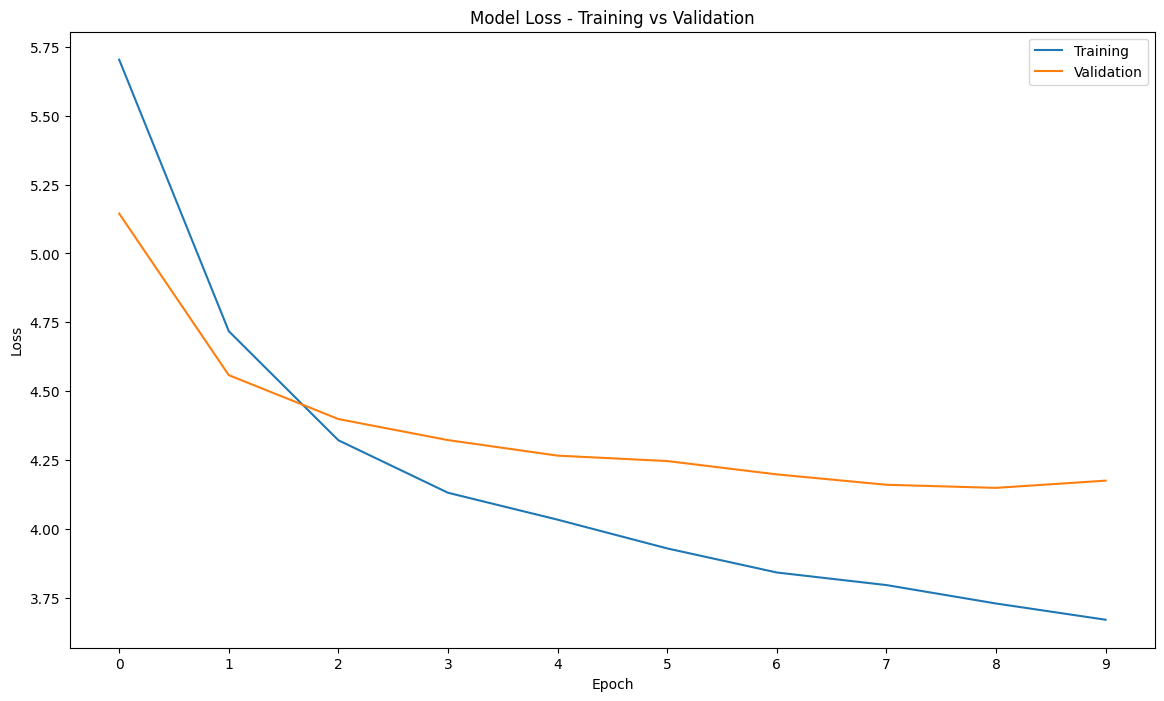

In [35]:
plt.figure(figsize=(14, 8))
plt.plot(train_loss)
plt.plot(val_loss)
plt.title("Model Loss - Training vs Validation")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.xticks(range(10))
plt.legend(["Training", "Validation"], loc="upper right")
plt.show()

# BLEU SCORE

In [36]:
predicted_captions = []
for i in range(test_set_length):
    encoded_inp = encoded_test_images[test_imgs[i].split(".")[0]]
    pred = caption_generator(
        photo=encoded_inp,
        model=model,
        max_length=train_max_len,
        wordtoix=wordtoix,
        ixtoword=ixtoword,
    )
    predicted_captions.append(pred)
predicted_captions[1:5]

[['startseq',
  'man',
  'in',
  'red',
  'shirt',
  'is',
  'riding',
  'down',
  'the',
  'water',
  'endseq'],
 ['startseq',
  'man',
  'in',
  'red',
  'shirt',
  'is',
  'riding',
  'on',
  'the',
  'street',
  'endseq'],
 ['startseq',
  'man',
  'in',
  'black',
  'shirt',
  'and',
  'white',
  'and',
  'white',
  'and',
  'white',
  'and',
  'white',
  'and',
  'white',
  'and',
  'white',
  'and',
  'white',
  'and',
  'white',
  'and',
  'white',
  'and',
  'white',
  'and',
  'white',
  'and',
  'white',
  'and',
  'white',
  'and',
  'white',
  'and',
  'white'],
 ['startseq', 'the', 'football', 'player', 'in', 'the', 'football', 'endseq']]

In [37]:
actual_captions = []
for i in test_imgs:
    actual_captions.append(desc_dict[i.split(".")[0]])
len(actual_captions)

1000

In [38]:
import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu


def remove_tokens(caption):
    """
    Remove start and end sequence tokens from the caption string.

    Inputs:
        caption (str): The caption string containing start and end sequence tokens.

    Returns:
        str: The caption string with the start and end sequence tokens removed.

    """
    caption = caption.replace("startseq ", "")
    caption = caption.replace(" endseq", "")
    return caption


def findBleuScore(predicted_captions, ground_truth_captions):
    """
    Computes the BLEU-1, BLEU-2, BLEU-3, and BLEU-4 scores for a set of predicted captions
    given the ground truth captions.

    Inputs:
        predicted_captions (list of list of str): A list of predicted captions, where each caption is
            represented as a list of words.
        ground_truth_captions (list of list of list of str): A list of ground truth captions for each image,
            where each image can have multiple captions. Each caption is represented as a list of words.

    Returns:
        None. Prints the BLEU-1, BLEU-2, BLEU-3, and BLEU-4 scores.

    """
    captions = []

    for caption in predicted_captions:
        readable_caption = " ".join(caption)
        captions.append(readable_caption)

    readable_captions = [remove_tokens(caption) for caption in captions]
    predicted_captions = readable_captions

    # Tokenize the predicted captions
    tokenized_predicted_captions = [caption.split() for caption in predicted_captions]

    # Remove 'startseq' and 'endseq' and tokenize the ground truth captions
    tokenized_ground_truth_captions = []

    for image_captions in ground_truth_captions:
        image_captions_tokenized = [caption.split()[1:-1] for caption in image_captions]
        tokenized_ground_truth_captions.append(image_captions_tokenized)

    # Compute the BLEU scores
    bleu1 = corpus_bleu(
        tokenized_ground_truth_captions,
        tokenized_predicted_captions,
        weights=(1, 0, 0, 0),
    )
    bleu2 = corpus_bleu(
        tokenized_ground_truth_captions,
        tokenized_predicted_captions,
        weights=(0.5, 0.5, 0, 0),
    )
    bleu3 = corpus_bleu(
        tokenized_ground_truth_captions,
        tokenized_predicted_captions,
        weights=(0.33, 0.33, 0.33, 0),
    )
    bleu4 = corpus_bleu(
        tokenized_ground_truth_captions,
        tokenized_predicted_captions,
        weights=(0.25, 0.25, 0.25, 0.25),
    )

    print("BLEU-1 score: ", bleu1)
    print("BLEU-2 score: ", bleu2)
    print("BLEU-3 score: ", bleu3)
    print("BLEU-4 score: ", bleu4)


findBleuScore(predicted_captions, actual_captions)

BLEU-1 score:  0.3889454397394137
BLEU-2 score:  0.21989477295608068
BLEU-3 score:  0.11557703611688783
BLEU-4 score:  0.054618637931026094


# Inference

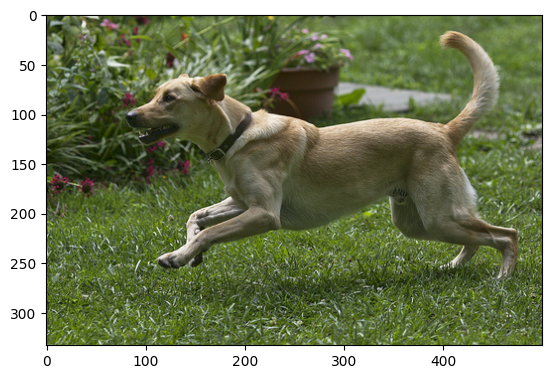

1/1 [==============================] - 0s 45ms/step
Predicted Caption: two dogs are running in the grass

Actual Captions
 brown dog running 
 brown dog running over grass 
 brown dog with its front paws off the ground on grassy surface near red and purple flowers 
 dog runs across grassy lawn near some flowers 
 yellow dog is playing in grassy area near flowers 
BLEU-1 score:  0.4953587998572467
BLEU-2 score:  9.77487297713204e-155
BLEU-3 score:  6.412135627211214e-204
BLEU-4 score:  1.3731144660140744e-231


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [40]:
for i in [5]:
    image1 = test_imgs[i]
    imagepath = os.path.join(img_folder, image1)
    image_1 = Image.open(imagepath)
    plt.imshow(image_1)
    plt.show()

    # Get the features of the image
    encoded_inp = get_features(
        img_folder, test_imgs[i], pretrained_model, pretrained_input_size
    )

    # Generate the caption for the image
    pred = caption_generator(
        photo=encoded_inp,
        model=model,
        max_length=val_max_len,
        wordtoix=wordtoix,
        ixtoword=ixtoword,
    )

    # Print the predicted caption for the image
    print(f"Predicted Caption: {' '.join(pred[1:-1])}")

    # Print the actual captions for the image
    print("\nActual Captions")

    # Compute the BLEU score between the predicted and actual captions for the image
    for capt in desc_dict[test_imgs[i].split(".")[0]]:
        print(capt.replace("startseq", "").replace("endseq", ""))

    # BLEU Score
    act_cap = [actual_captions[i]]
    findBleuScore([pred], act_cap)

## Using optimal model weights (epoch = 5)

In [43]:
loaded_model = load_model(
    f"/content/drive/MyDrive/{key}/trained_model_2epochs.h5"
)

In [ ]:
for i in [150]:
    image1 = test_imgs[i]
    imagepath = os.path.join(img_folder, image1)
    image_1 = Image.open(imagepath)
    plt.imshow(image_1)
    plt.show()

    # Get the features of the image
    encoded_inp = get_features(
        img_folder, test_imgs[i], pretrained_model, pretrained_input_size
    )

    # Generate the caption for the image
    pred = caption_generator(
        photo=encoded_inp,
        model=loaded_model,
        max_length=train_max_len,
        wordtoix=wordtoix,
        ixtoword=ixtoword,
    )

    # Print the predicted caption for the image
    print(f"Predicted Caption: {' '.join(pred[1:-1])}")

    # Print the actual captions for the image
    print("\nActual Captions")
    for capt in desc_dict[test_imgs[i].split(".")[0]]:
        print(capt.replace("startseq", "").replace("endseq", ""))

    # Compute the BLEU score between the predicted and actual captions for the image
    act_cap = [actual_captions[i]]
    findBleuScore([pred], act_cap)